# Requirements

In [1]:
# Import required modules
import os
import toml
import zipfile
import numpy
import pyKVFinder
import nglview

In [2]:
# Unzip required files
if not os.path.isdir('./data'):
    with zipfile.ZipFile('./data.zip', 'r') as zipped:
        zipped.extractall('./data')

In [3]:
# Get DALI proteins
pdbs = [f for f in sorted(os.listdir('./data')) if f.endswith('.pdb')][:-1]
print(pdbs)

# Get ligand pdb
ligand = './data/APR.pdb'

['2ACF.pdb', '2VRI.pdb', '3EJG.pdb', '3JZT.pdb', '5HOL.pdb', '6MEA.pdb', '6W02.pdb']


In [4]:
# Define a common custom box using parKVFinder's PyMOL plugin
box = {
    'box':{
        'p1': [ 2.03, -3.97, 7.72,],
        'p2': [ 18.93, -3.97, 7.72,],
        'p3': [ 2.03, 16.23, 7.72,],
        'p4': [ 2.03, -3.97, 33.72,],
    }
}

# Write common custom box to file
with open('box.toml', 'w') as f:
    toml.dump(box, f)

# Evolutive analysis

In [5]:
# Read van der Waals dictionary
vdw = pyKVFinder.read_vdw()

# Read ligand atomic coordinates
_, lxyzr = pyKVFinder.read_pdb(ligand, vdw)

# hydropathy
hydropathy = {}
frequency = {}

for pdb in pdbs:
    # Load atomic coordinates and information
    resinfo, xyzr = pyKVFinder.read_pdb(os.path.join('./data', pdb), vdw)
    
    # Get grid from file
    vertices, resinfo, xyzr, sincos, nx, ny, nz = pyKVFinder.get_grid_from_file('./box.toml', resinfo, xyzr, probe_out=8.0)
    
    # Detect biomolecular cavities
    ncav, cavities = pyKVFinder.detect(nx, ny, nz, xyzr, vertices, sincos, probe_out=8.0, lxyzr=lxyzr, volume_cutoff=50.0)

    # Constitutional characterization
    residues = pyKVFinder.constitutional(cavities, resinfo, xyzr, vertices, sincos, ncav, ignore_backbone=True)
    frequencies = pyKVFinder.calculate_frequencies(residues)
    
    # Accumulate frequency
    frequency[f"{pdb.replace('.pdb', '')}"] = frequencies['KAA']['RESIDUES']
    
    # Depth characterization
    depths, max_depth, avg_depth = pyKVFinder.depth(cavities, ncav)
    
    # Spatial characterization
    surface, volume, area = pyKVFinder.spatial(cavities, ncav)
    
    # Hydropathy characterization
    scales, avg_hydropathy = pyKVFinder.hydropathy(surface, resinfo, xyzr, vertices, sincos, ncav, ignore_backbone=True)
    
    # Accumulate hydropathy arrays
    hydropathy[f"{pdb.replace('.pdb', '')}"] = scales.reshape(-1)
    
    # Export cavities
    output_cavity = f"./results/{pdb.replace('.pdb', '')}.cavities.pdb"
    output_hydropathy = f"./results/{pdb.replace('.pdb', '')}.EisenbergWeiss.pdb"
    pyKVFinder.export(output_cavity, cavities, surface, vertices, sincos, ncav=ncav, output_hydropathy=output_hydropathy, scales=scales)
    
    # Write results
    output_results = f"./results/{pdb.replace('.pdb', '')}.results.toml"
    pyKVFinder.write_results(output_results, pdb=pdb, ligand=ligand, output=output_cavity, output_hydropathy=output_hydropathy, volume=volume, area=area, max_depth=max_depth, avg_depth=avg_depth, avg_hydropathy=avg_hydropathy, residues=residues, frequencies=frequencies)

## Data analysis

In [6]:
# Import required packages
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import matplotlib.pyplot as plt

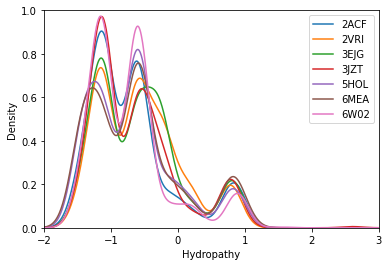

In [7]:
# Plot kde distributions
data = pd.DataFrame(hydropathy).replace(0.0, numpy.nan)
ax = data.plot.kde()
ax.set_xlim(-2, 3)
ax.set_ylim(0, 1)
ax.set_xlabel('Hydropathy')

# Save to file
fig = ax.get_figure()
os.mkdir('./results/plots') if not os.path.exists('./results/plots') else None
fig.savefig('./results/plots/kde.png', dpi=300)

In [8]:
# Compare k-samples distributions with Anderson-Darling test

# Prepare data
data = list(hydropathy.values())

# Perform Anderson-Darling test for k-samples
stats, critical_values, significance = scipy.stats.anderson_ksamp(data)

# Show significance
print("> Samples are drawn from a different distributions!")
print(f"p-value: {significance}")

> Samples are drawn from a different distributions!
p-value: 0.001


<ipython-input-8-5c5d43580797>:7: UserWarning: p-value floored: true value smaller than 0.001
  stats, critical_values, significance = scipy.stats.anderson_ksamp(data)


<ipython-input-9-ef2ea5056c14>:8: UserWarning: p-value capped: true value larger than 0.25
  _, _, pairwise[key][key2] = scipy.stats.anderson_ksamp([hydropathy[key], hydropathy[key2]])
<ipython-input-9-ef2ea5056c14>:8: UserWarning: p-value floored: true value smaller than 0.001
  _, _, pairwise[key][key2] = scipy.stats.anderson_ksamp([hydropathy[key], hydropathy[key2]])


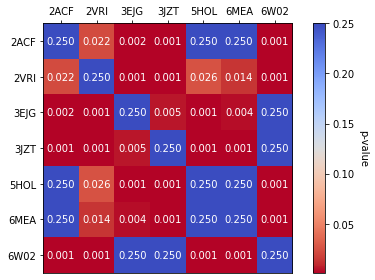

In [9]:
# Pairwise comparison between samples using Anderson-Darling test

# Perform Anderson-Darling test on each sample pair
pairwise = {}
for key in hydropathy.keys():
    pairwise[key] = {}
    for key2 in hydropathy.keys():
        _, _, pairwise[key][key2] = scipy.stats.anderson_ksamp([hydropathy[key], hydropathy[key2]])

# Prepare data
data = pd.DataFrame.from_dict(pairwise)
labels = list(hydropathy.keys())

# Heatmap
ax = plt.gca()
im = ax.imshow(data, cmap='coolwarm_r')

# Change tick labels
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_xticks(numpy.arange(len(labels)))
ax.set_yticks(numpy.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Include colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('p-value', rotation=-90, va="bottom")

# Loop over data dimensions and create text annotations.
for i in range(len(hydropathy.keys())):
    for j in range(len(hydropathy.keys())):
        text = ax.text(j, i, f'{data.iloc[i, j]:.3f}', ha="center", va="center", color="w")

# Save to file
plt.tight_layout()
plt.savefig('./results/plots/heatmap.png')

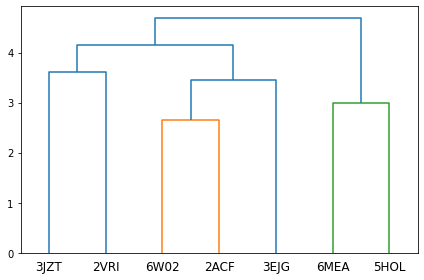

In [10]:
# Hierarchical clustering of residues frequency

# Prepare data
data = pd.DataFrame.from_dict(frequency, orient='index').replace(numpy.nan, 0.0)

# Calculate distances
linked = linkage(data, method='average', metric='euclidean')

# Create dendogram
scipy.cluster.hierarchy.dendrogram(linked, orientation='top', labels=data.index, distance_sort='descending', show_leaf_counts=True)

# Save to file
plt.tight_layout()
plt.savefig('./results/plots/dendogram.png', dpi=300)